## Exploratory Data Analysis of Predicting the Remaining Useful Life of NASA Turbofan Engines 
### Please refer to `final_script.ipynb` for the Final Report data reproduction script. This is only the EDA script. Thank you!

In [87]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# unit + time + 3 operational settings + 21 sensors = 26 cols total
column_names = [
    "unit", "time", "op_setting_1", "op_setting_2", "op_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]  

In [88]:
# train_FD001 simulation's conditions: ONE (Sea Level) and Fault Modes: ONE (HPC Degradation) 
df1 = pd.read_csv('/Users/JoyceShiah/Documents/GitHub/dsc288r_capstone/data/train_FD001.txt', sep="\s+", header=None, names=column_names, index_col=False)

NOTE TO SELF: need `index_col = False` in order to correctly format `unit` and `time` columns (parse as integers) 

In [89]:
print(df1.info())
print(df1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit          20631 non-null  int64  
 1   time          20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor_14     20631 non-nu

## Data Cleaning and Pre-processing Stage

### Step 1: Identify & remove sensor columns w/ significant missing values, nulls, outliers
- drop if: columns contain only constant values
- before dropping them, verify if either provide meaningful variance

In [90]:
print(df1.nunique())

unit             100
time             362
op_setting_1     158
op_setting_2      13
op_setting_3       1
sensor_1           1
sensor_2         310
sensor_3        3012
sensor_4        4051
sensor_5           1
sensor_6           2
sensor_7         513
sensor_8          53
sensor_9        6403
sensor_10          1
sensor_11        159
sensor_12        427
sensor_13         56
sensor_14       6078
sensor_15       1918
sensor_16          1
sensor_17         13
sensor_18          1
sensor_19          1
sensor_20        120
sensor_21       4745
dtype: int64


#### Check for Missing Values

In [91]:
print(df1.isnull().sum())

unit            0
time            0
op_setting_1    0
op_setting_2    0
op_setting_3    0
sensor_1        0
sensor_2        0
sensor_3        0
sensor_4        0
sensor_5        0
sensor_6        0
sensor_7        0
sensor_8        0
sensor_9        0
sensor_10       0
sensor_11       0
sensor_12       0
sensor_13       0
sensor_14       0
sensor_15       0
sensor_16       0
sensor_17       0
sensor_18       0
sensor_19       0
sensor_20       0
sensor_21       0
dtype: int64


### Step 2: Sort Data by `unit` and `time` 
Since each unit runs for a certain time until engine failure, organize data by unit and progression of time.

In [92]:
df1 = df1.sort_values(by=["unit", "time"])
df1.head()

,unit,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Step 3: Calculate assigned Remaining Useful Life (RUL = number of time steps left before engine failure) value
- calculated RUL value --> TARGET VARIABLE for model (y variable)
- `RUL = Final Cycle − Current Cycle`
- formula for target RUL calculation: `.transform(lambda x: x.max() - x)`
    - group the data by each **engine** unit.
    - each engine has **multiple time steps**, starting from time = 1 and increasing until failure
    - for each engine, this finds the **maximum time value** (max = last recorded cycle before failure)
- `x.max() - x`
    - finds how many time steps are left before failure
    - e.g. RUL = 150 − 125 = 25
        - if an engine runs for 150 cycles and the current row has time = 125
- `.transform()` ensures calculation is applied within **each engine unit**, maintaining the original DataFrame structure

**Why this step of assigning RUL values (serves as the target variable for training your XGBoost model) is essential for building the adaptive sliding window approach:**

- goal is to predict RUL at each time step, so without calculating RUL first, you wouldn't have a supervised learning target for XGBoost
- adaptive sliding window model **learns from past sensor readings to predict future RUL**, so you need a **well-defined RUL label** for training
- adaptive sliding window approach dynamically adjusts the window size based on engine degradation rates. This means:
    - if an engine is **degrading slowly**, a longer history (larger window) is useful
    - If an engine is **degrading rapidly**, a shorter history (smaller window) is needed to focus on recent changes
- analyzing sensor behavior is critical for success in engine sustainability: without RUL, you wouldn't know how close an engine is to failure, making it impossible to adjust window size adaptively


**Difference between Fixed vs. Adaptive Sliding Window Approach:**

- Since this is comparing fixed vs. adaptive sliding windows, both need a consistent target variable --> RUL
- **Fixed Window:** uses a constant-length past sequence for prediction
    - fixed number of past time steps (e.g., the last 30 or 50 readings)
- **Adaptive Window:** uses RUL trends to adjust window size dynamically, so if RUL weren’t calculated first, it would be unclear when to adjust the window size, making adaptive modeling ineffective

In [93]:
df1["RUL"] = df1.groupby("unit")["time"].transform(lambda x: x.max() - x)

In [94]:
df1.head()

,unit,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### Step 4: Visualization of the Calculated RUL distribution 
- visualize calculated RUL for each engine unit in FD001 Train dataset

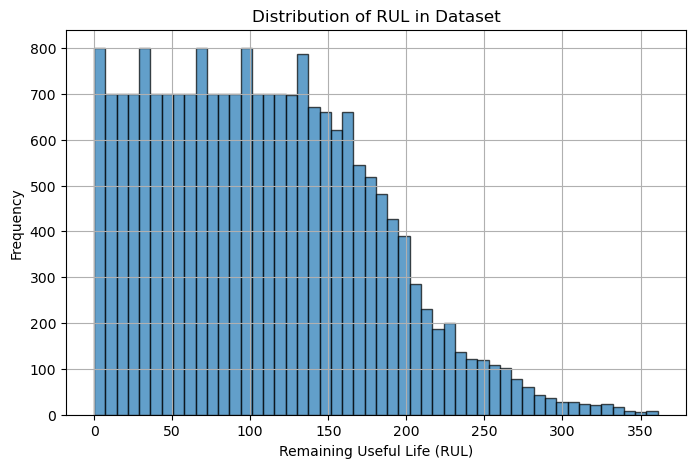

In [95]:
# max cycle per unit (engine)
max_cycle_per_unit = df1.groupby("unit")["time"].max()

# merge df to compute RUL
df1["RUL"] = df1["unit"].map(max_cycle_per_unit) - df1["time"]

plt.figure(figsize=(8, 5))
plt.hist(df1["RUL"], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Remaining Useful Life (RUL)")
plt.ylabel("Frequency")
plt.title("Distribution of RUL in Dataset")
plt.grid(True)
plt.show()

### Discussion of graph:
- right-skewed distribution
- however, from 0 to around 128 RUL, there is a sudden spike every 20-30 RUL increments that go up to frequency of 800

#### Step 4.1: Going further into analysis of graph
Check `Frequency` table for RUL, to see if the RUL increments are artificially grouped

In [96]:
df1["RUL"].value_counts().sort_index().head(50)  # check the first 50 RUL values

RUL
0     100
1     100
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
11    100
12    100
13    100
14    100
15    100
16    100
17    100
18    100
19    100
20    100
21    100
22    100
23    100
24    100
25    100
26    100
27    100
28    100
29    100
30    100
31    100
32    100
33    100
34    100
35    100
36    100
37    100
38    100
39    100
40    100
41    100
42    100
43    100
44    100
45    100
46    100
47    100
48    100
49    100
Name: count, dtype: int64

Compare with `Engine` IDs

In [97]:
df1.groupby("RUL")["unit"].nunique().head(50)  # how many unique engines share the same RUL

RUL
0     100
1     100
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
11    100
12    100
13    100
14    100
15    100
16    100
17    100
18    100
19    100
20    100
21    100
22    100
23    100
24    100
25    100
26    100
27    100
28    100
29    100
30    100
31    100
32    100
33    100
34    100
35    100
36    100
37    100
38    100
39    100
40    100
41    100
42    100
43    100
44    100
45    100
46    100
47    100
48    100
49    100
Name: unit, dtype: int64

#### Step 4.2: Overlay a Kernel Density Estimate (KDE)

#### Discussion of analysis 
- for every Remaining Useful Life (RUL) value from 0 to 49, there are exactly 100 rows in the dataset where that RUL value appears
- since each row corresponds to an engine at a specific time step, this suggests that at every RUL step from 0 to 49, 100 different engines are recorded at that exact RUL value
- NASA C-MAPSS dataset follows a structured simulation, ensuring that each engine degrades in a uniform way
- all 100 engines reach RUL = 0 at some point, and they pass through the same RUL values at the same frequency during degradation

#### More about KDE Visualization
- visualize the distribution of data points in a smooth manner
    - KDE takes a set of data points and smooths them into a continuous curve
    - uses a kernel (a small window) around each data point to contribute to the overall density estimation
 
Since the data used for modeling from the NASA dataset is primarily continuous, 
- ##### features:
    - sensor measurements --> temperature, pressure, rotational speed, fuel flow
    - operational settings --> are typically recorded as continuous numerical values
    - RUL Values: continuous variable representing the estimated time until a failure occurs, which can also vary smoothly based on the operational conditions of the engines
 
**So, KDE is a preferred visualization over histograms:** 
- KDE is especially useful for continuous data where you expect the distribution to change smoothly
- can capture the density's shape without being constrained by discrete bin edges
- from Seaborn documentation: KDE can produce a plot that is less cluttered and more interpretable, especially when drawing multiple distributions

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


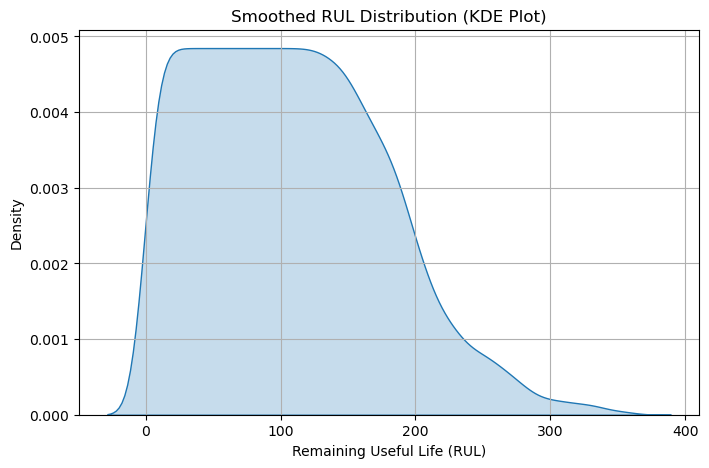

In [98]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.kdeplot(df1["RUL"], fill=True, bw_adjust=1)
plt.xlabel("Remaining Useful Life (RUL)")
plt.ylabel("Density")
plt.title("Smoothed RUL Distribution (KDE Plot)")
plt.grid(True)
plt.show()

### Discussion of KDE plot
- drop from 100 to 99 at RUL 128 means one engine unit had RUL = 128 cycles left
- not every engine unit reaches full capacity every cycle (natural wear and tear); some engines degrade faster than others, so they may fail before reaching RUL 128 

### Step 4.2: Analyze RUL distribution beyond 50 and check for similar patterns:

In [99]:
df1["RUL"].value_counts().sort_index()[100:150]  # See counts for RUL values between 100-150

RUL
100    100
101    100
102    100
103    100
104    100
105    100
106    100
107    100
108    100
109    100
110    100
111    100
112    100
113    100
114    100
115    100
116    100
117    100
118    100
119    100
120    100
121    100
122    100
123    100
124    100
125    100
126    100
127    100
128     99
129     99
130     99
131     99
132     99
133     99
134     99
135     98
136     98
137     96
138     96
139     96
140     96
141     96
142     96
143     96
144     96
145     96
146     96
147     94
148     94
149     94
Name: count, dtype: int64

In [100]:
df1.groupby("RUL")["unit"].nunique()[100:150]


RUL
100    100
101    100
102    100
103    100
104    100
105    100
106    100
107    100
108    100
109    100
110    100
111    100
112    100
113    100
114    100
115    100
116    100
117    100
118    100
119    100
120    100
121    100
122    100
123    100
124    100
125    100
126    100
127    100
128     99
129     99
130     99
131     99
132     99
133     99
134     99
135     98
136     98
137     96
138     96
139     96
140     96
141     96
142     96
143     96
144     96
145     96
146     96
147     94
148     94
149     94
Name: unit, dtype: int64

### Step 4.3: Calculate the correlation matrix for the features to identify relationships between sensor data, operational settings, and RUL. 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


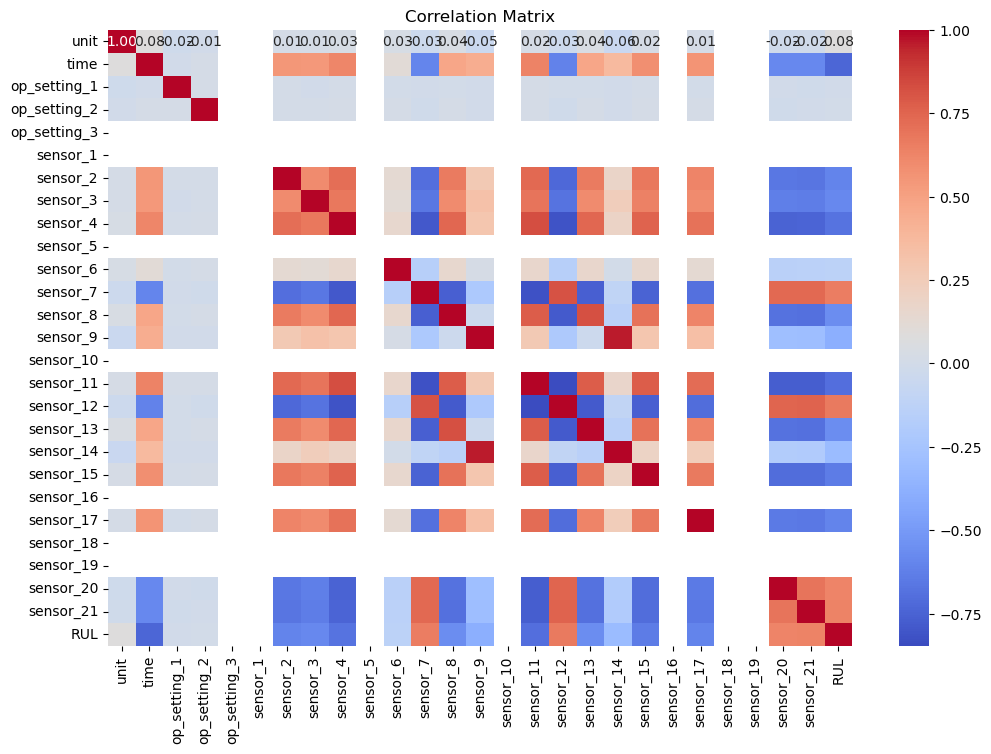

In [101]:
plt.figure(figsize=(12, 8))
correlation_matrix = df1.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Start with a Common Threshold: Begin with a threshold of 0.5, as it's a commonly used benchmark for indicating a moderate to strong correlation.

In [102]:
correlation_matrix = df1.corr()

# set a threshold for filtering (default)
threshold = 0.5

# find significant correlations
significant_correlations = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]
print(significant_correlations.stack().reset_index().rename(columns={0: 'correlation'}))

    level_0    level_1  correlation
0      unit       unit     1.000000
1      time       time     1.000000
2      time   sensor_2     0.549898
3      time   sensor_3     0.543947
4      time   sensor_4     0.624577
..      ...        ...          ...
195     RUL  sensor_15    -0.642667
196     RUL  sensor_17    -0.606154
197     RUL  sensor_20     0.629428
198     RUL  sensor_21     0.635662
199     RUL        RUL     1.000000

[200 rows x 3 columns]


#### Display 10 highest and bottom 10 correlations

In [103]:
correlation_matrix = df1.corr()

threshold = 0.5

significant_correlations = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

# retrieve significant correlations, reset index
significant_correlations = significant_correlations.stack().reset_index().rename(columns={0: 'correlation'})

# filter out self-correlations (own variable)
significant_correlations = significant_correlations[significant_correlations['level_0'] != significant_correlations['level_1']]

# find top 10 highest correlations
top_10_correlations = significant_correlations.nlargest(10, 'correlation')

# find bottom 10 lowest correlations (most negative)
bottom_10_correlations = significant_correlations.nsmallest(10, 'correlation')

print("Top 10 Highest Correlations:")
print(top_10_correlations)

print("\nBottom 10 Lowest Correlations:")
print(bottom_10_correlations)

Top 10 Highest Correlations:
       level_0    level_1  correlation
86    sensor_9  sensor_14     0.963157
128  sensor_14   sensor_9     0.963157
49    sensor_4  sensor_11     0.830136
90   sensor_11   sensor_4     0.830136
79    sensor_8  sensor_13     0.826084
119  sensor_13   sensor_8     0.826084
65    sensor_7  sensor_12     0.812713
105  sensor_12   sensor_7     0.812713
77    sensor_8  sensor_11     0.782213
92   sensor_11   sensor_8     0.782213

Bottom 10 Lowest Correlations:
       level_0    level_1  correlation
94   sensor_11  sensor_12    -0.846884
107  sensor_12  sensor_11    -0.846884
64    sensor_7  sensor_11    -0.822805
91   sensor_11   sensor_7    -0.822805
50    sensor_4  sensor_12    -0.815591
104  sensor_12   sensor_4    -0.815591
47    sensor_4   sensor_7    -0.793130
61    sensor_7   sensor_4    -0.793130
109  sensor_12  sensor_13    -0.788441
121  sensor_13  sensor_12    -0.788441


### Discussion of Top 10, Bottom 10 Correlation Analysis
Top 10 Highest Correlations:
- pairs like `sensor_9` and `sensor_14` have a very high correlation of 0.963
    - shows that as one sensor's readings increase, the other sensor's readings tend to increase as well --> suggesting a strong linear relationship
- **From GPT:** high correlations (like those above 0.8) might suggest redundancy in your features, as they provide similar information. You may consider selecting one of the correlated sensors for modeling to reduce multicollinearity.

Bottom 10 Lowest Correlations:
- pairs such as `sensor_11` and `sensor_12`, have a strong negative correlation of -0.847
    - as one sensor's readings increase, the other sensor's readings tend to decrease --> inverse relationship

In [104]:
# # Testing different thresholds
# thresholds = [0.3, 0.5, 0.7, 0.9]
# for threshold in thresholds:
#     significant_correlations = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]
#     print(f"\nSignificant correlations at threshold {threshold}:")
#     print(significant_correlations.stack().reset_index().rename(columns={0: 'correlation'}))

### Step 4.4: Analyze Sensor Trends 
- stable line: relatively horizontal line = relatively stable over the observed time period
    - engine is operating under stable conditions or  internal calibration problems

- fluctuating line: varying readings (not horizontal) = sensors reacting to changing operational conditions
    - may be valuable for understanding engine performance and health

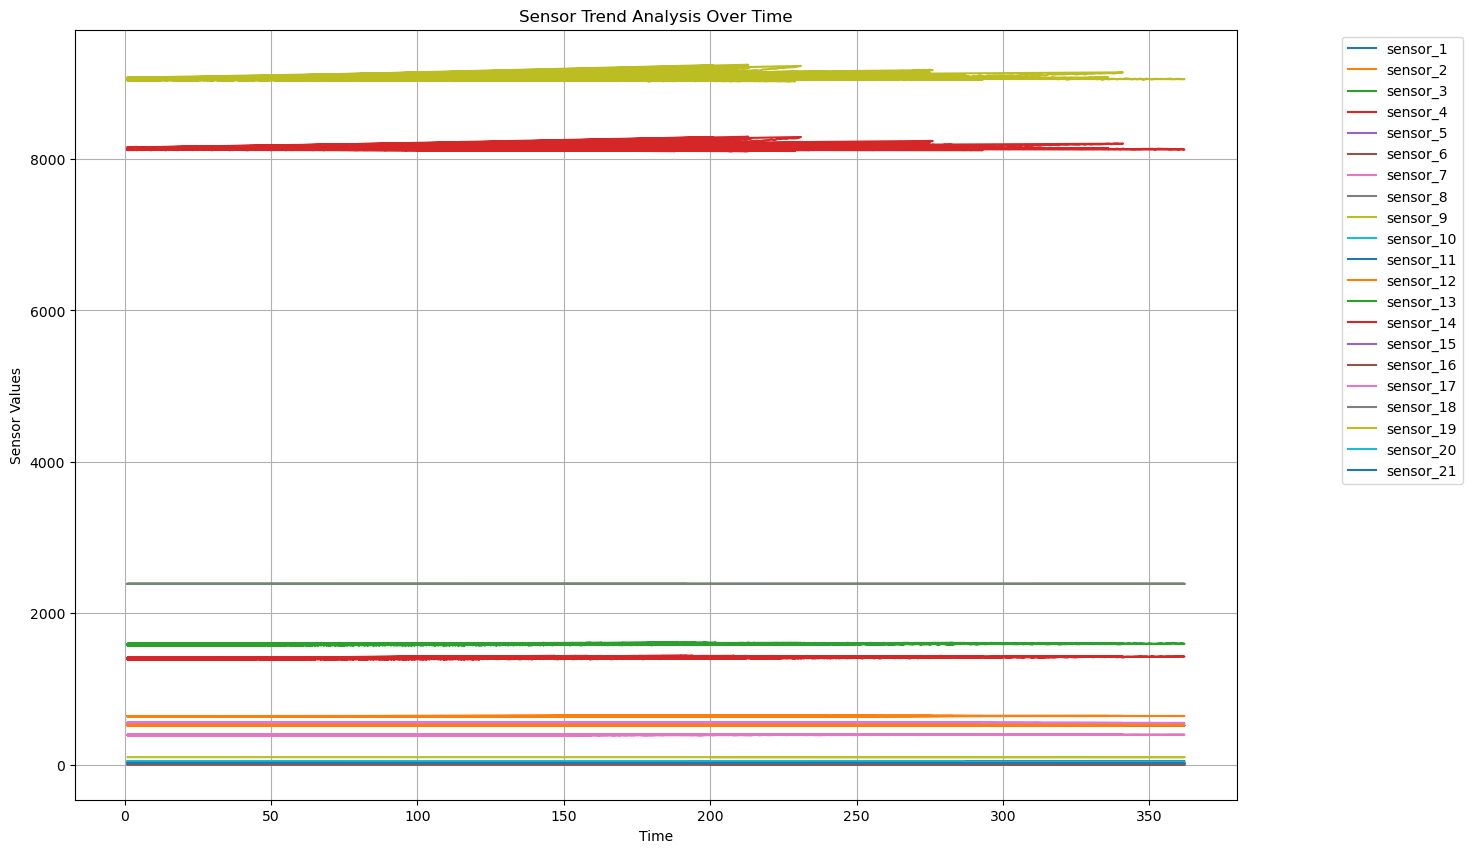

In [105]:
# analyze all sensors from 1 to 21)
key_sensors = [f'sensor_{i}' for i in range(1, 22)]

# plot each selected sensor on 1 graph
plt.figure(figsize=(15, 10))
for sensor in key_sensors:
    plt.plot(df1['time'], df1[sensor], label=sensor)
plt.title('Sensor Trend Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Sensor Values')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid()
plt.show()

### Sanity Check on # of columns

In [106]:
len(df1.columns)

27

# Addressing TA's feedback from Milestone 2:

"No discussion on feature extraction: The report states that raw sensor data is sufficient, but it does not explore whether transformations (e.g., moving averages, trend indicators) could improve model performance.

Handling of temporal dependencies: Since engine degradation follows a time series pattern, no mention is made of temporal features (e.g., cumulative degradation metrics, rolling window statistics)."

### Temporal features implememtation

#### Cumulative degradation metrics
Remaining cycles (RUL) decreases over time. A cumulative sum of certain sensor readings (e.g., total vibration or temperature increase) can help model degradation better.

In [107]:
df1['sensor_2_cumsum'] = df1.groupby("unit")['sensor_2'].cumsum()

#### Rolling Window Statistics
Compute moving averages or standard deviations of sensor values over a window (e.g., last 5 cycles) to capture short-term trends.

In [108]:
window_size = 5
for sensor in sensors:
    df1[f"{sensor}_rolling_mean"] = df1.groupby("unit")[sensor].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    df1[f"{sensor}_rolling_std"] = df1.groupby("unit")[sensor].rolling(window=window_size).std().reset_index(level=0, drop=True)

## Feature Importance Analysis Stage
#### Preparing for RUL Prediction (USING RAW FEATURES (from NASA CMAPSS `df1` dataset) ONLY)

In [109]:
# using df1 "RAW features only" Feature Importance model 

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# original sensor features
sensor_columns = [f"sensor_{i}" for i in range(1, 22)]
op_settings = ["op_setting_1", "op_setting_2", "op_setting_3"]
feature_columns = sensor_columns + op_settings

df1['RUL'] = df1.groupby('unit')['time'].transform(lambda x: x.max() - x)  # Example RUL calculation

# split into features and target
X = df1[feature_columns]
y = df1['RUL'] # calc RUL from EDA stage

# split data into training and validation sets
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# train XGBoost model
xgb_raw = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_raw.fit(X_train_raw, y_train_raw)

# predict and evaluate
y_pred_raw = xgb_raw.predict(X_val_raw)
rmse_raw = mean_squared_error(y_val_raw, y_pred_raw, squared=False)

print(f"Baseline Model (Raw Features) RMSE: {rmse_raw:.4f}")

Baseline Model (Raw Features) RMSE: 43.4001


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


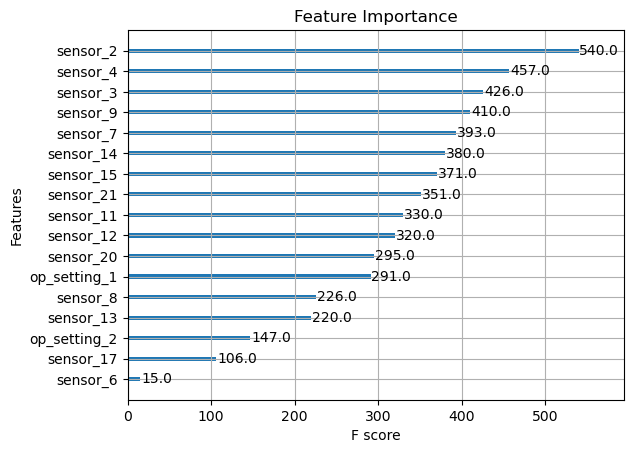

In [110]:
# visualize
xgb.plot_importance(xgb_raw)
plt.title('Feature Importance')
plt.show()

### Discussion of Feature Importance XGBoost model on RAW Features only 
Top Features Contributing to RUL Prediction
- Most Significant Sensors:
    - sensor_2: F score = 540.0
    - sensor_4: F score = 457.0
    - sensor_3: F score = 426.0
    - sensor_9: F score = 410.0
    - sensor_7: F score = 393.0
- Additional Noteworthy Sensors:
    - sensor_14: F score = 380.0
    - sensor_15: F score = 371.0
    - sensor_21: F score = 351.0
    - sensor_11: F score = 330.0
    - sensor_12: F score = 320.0
    - sensor_20: F score = 295.0
- Operational Settings:
    - op_setting_1: F score = 291.0
    - op_setting_2: F score = 220.0
    - op_setting_2: F score = 147.0
- Least Important Features:
    - sensor_17: F score = 106.0
    - sensor_6: F score = 15.0

### Compared to Wang, T., Yu, J., Siegel, D., & Lee, J. (2008):
- A similarity based prognostics approach for remaining useful life estimation of engineered systems' report
     - Common sensors: 2, 3, 4, 7, 11, 12, 15, 20, 21
     - **Next action:** Sensor 9 & 14 could capture short-term variations that improve RMSE but weren’t manually chosen by Wang et al.

## Selected Sensor subsets
- Model 1: Wang et al.’s sensors → (2, 3, 4, 7, 11, 12, 15, 20, 21)
- Model 2: XGBoost’s top-ranked sensors → (2, 3, 4, 7, 9, 11, 12, 14, 15, 21)
- Model 3: All sensors → (1–21)

#### Step 1: Compute Feature Correlation
Check whether sensor 9 and sensor 14 are highly correlated with Wang et al.’s selected sensors.

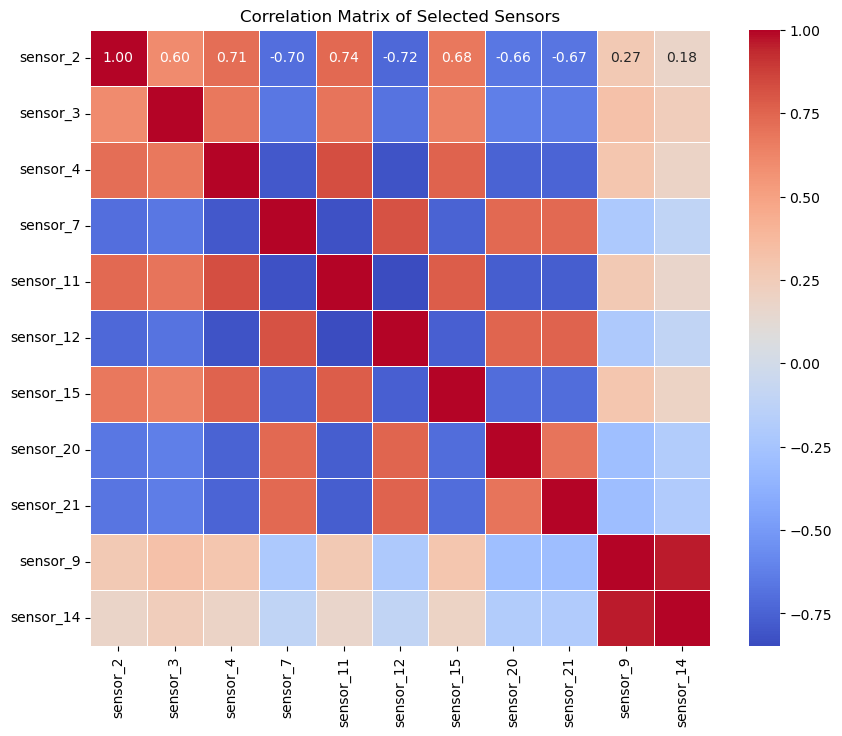

In [111]:
# sensors from Wang et al. (2008)
wang_sensors = ["sensor_2", "sensor_3", "sensor_4", "sensor_7", "sensor_11", "sensor_12", "sensor_15", "sensor_20", "sensor_21"]

# Sensors XGBoost used that Wang et al. did not
extra_sensors = ["sensor_9", "sensor_14"]

# subset of relevant sensors
selected_sensors = wang_sensors + extra_sensors

correlation_matrix = df1[selected_sensors].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Selected Sensors")
plt.show()

#### Discussion: Sensor 9 or sensor 14 have a very high correlation (0.963) with Wang et al.’s sensors. 

#### Step 2: Train Three Models & Compare RMSE
Train and evaluate three models using XGBoost

In [112]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 3 feature sets of sensors
X_wang = df1[wang_sensors] # Wang et al.'s subset
X_xgb = df1[list(set(wang_sensors + extra_sensors))]  # XGBoost-selected
X_all = df1[[f"sensor_{i}" for i in range(1, 22)]]  # all 21 sensors

y_train = df1["RUL"]

model_wang = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model_xgb = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model_all = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)

model_wang.fit(X_wang, y_train)
model_xgb.fit(X_xgb, y_train)
model_all.fit(X_all, y_train)

y_pred_wang = model_wang.predict(X_wang)
y_pred_xgb = model_xgb.predict(X_xgb)
y_pred_all = model_all.predict(X_all)

rmse_wang = np.sqrt(mean_squared_error(y_train, y_pred_wang))
rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb))
rmse_all = np.sqrt(mean_squared_error(y_train, y_pred_all))

print(f"RMSE using Wang et al. Sensors: {rmse_wang:.4f}")
print(f"RMSE using XGBoost Selected Sensors: {rmse_xgb:.4f}")
print(f"RMSE using All Sensors: {rmse_all:.4f}")


RMSE using Wang et al. Sensors: 33.5504
RMSE using XGBoost Selected Sensors: 29.0049
RMSE using All Sensors: 28.7453


# Important Discussion: Regarding Occam's Razor
XGBoost’s selected sensors (RMSE = 29.00) outperform Wang et al.’s selection (RMSE = 33.55)
- This suggests that sensors 9 and 14 provide valuable predictive information that Wang et al. overlooked.
- Your feature importance analysis was effective in selecting relevant sensors.

Using all sensors (RMSE = 28.75) only marginally improves RMSE compared to XGBoost’s selection (RMSE = 29.00)
- This implies that many of the extra sensors don’t add much value.
- Keeping fewer, highly relevant sensors can simplify the model while maintaining strong performance
    - aligns with **Occam's razor** --> simplest strategy is best for explaining data more accurately
    - Using fewer but more informative sensors reduces model complexity → This makes training faster, reduces overfitting risk, and keeps predictions interpretable.
    - So, unless the slight RMSE reduction from using all sensors (28.75 vs. 29.00) is critical, Occam’s Razor suggests sticking with the most important sensors instead of using everything.

In [113]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

model = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)


In [114]:
# compare all 3 sensor feature sets
X_wang = df1[wang_sensors]
X_xgb = df1[list(set(wang_sensors + extra_sensors))]  # XGBoost selected sensors (Wang's + XGBoost-selected) 
X_all = df1[[f"sensor_{i}" for i in range(1, 22)]]  # all 21 sensors

y_train = df1["RUL"]

# initialize xgb models
model_wang = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model_xgb = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model_all = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)

# train
model_wang.fit(X_wang, y_train)
model_xgb.fit(X_xgb, y_train)
model_all.fit(X_all, y_train)

# predictions
y_pred_wang = model_wang.predict(X_wang)
y_pred_xgb = model_xgb.predict(X_xgb)
y_pred_all = model_all.predict(X_all)

# calc RMSE
rmse_wang = np.sqrt(mean_squared_error(y_train, y_pred_wang))
rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb))
rmse_all = np.sqrt(mean_squared_error(y_train, y_pred_all))

print(f"RMSE using Wang et al. Sensors: {rmse_wang:.4f}")
print(f"RMSE using XGBoost Selected Sensors: {rmse_xgb:.4f}")
print(f"RMSE using All Sensors: {rmse_all:.4f}")

RMSE using Wang et al. Sensors: 33.5504
RMSE using XGBoost Selected Sensors: 29.0049
RMSE using All Sensors: 28.7453


## Feature Engineering
Scale using StandardScaler to significantly improve performance
- sensors have different ranges & units

In [115]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# scale features
X_wang_scaled = scaler.fit_transform(X_wang)
X_xgb_scaled = scaler.fit_transform(X_xgb)
X_all_scaled = scaler.fit_transform(X_all)

In [116]:
import xgboost as xgb
from xgboost import XGBRegressor
model_wang = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=500, random_state=42)

## Model Implementation stage
### `X_wang_scaled` applies sensors → (2, 3, 4, 7, 11, 12, 15, 20, 21)
#### Stacking (RMSE = 20.4869)

In [141]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [118]:
# X_wang_scaled
estimators = [
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]
model_stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
model_stack.fit(X_wang_scaled, y_train)
y_pred_stack = model_stack.predict(X_wang_scaled)

rmse_stack = np.sqrt(mean_squared_error(y_train, y_pred_stack))
print(f"RMSE using Stacking with Wang et al's sensors: {rmse_stack:.4f}")

RMSE using Stacking with Wang et al's sensors: 20.4869


#### Linear Regression (RMSE = 44.7125)

In [119]:
from sklearn.linear_model import LinearRegression
y_train = df1["RUL"]

linear_model = LinearRegression()

linear_model.fit(X_xgb_scaled, y_train)

y_pred_lr = linear_model.predict(X_xgb_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_lr))
print(f"RMSE using Linear Regression: {rmse_lr:.4f}")

RMSE using Linear Regression: 44.7125


#### Random Forest Regressor (RMSE = 17.3627)

In [120]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_wang_scaled, y_train)

y_pred_rf = rf_model.predict(X_wang_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
print(f"RMSE using Random Forest: {rmse_rf:.4f}")

RMSE using Random Forest: 17.3627


#### Gradient Boosting Regressor (RMSE = 44.5983)

In [121]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# train 
gb_model.fit(X_wang_scaled, y_train)

# predict
y_pred_gb = gb_model.predict(X_wang_scaled)

# calc RMSE
rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_gb))
print(f"RMSE using Gradient Boosting: {rmse_gb:.4f}")

RMSE using Gradient Boosting: 44.5983


#### K-Nearest Neighbors (KNN) Regressor (RMSE = 40.7499)

In [122]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_wang_scaled, y_train)

y_pred_knn = knn_model.predict(X_wang_scaled)

rmse_knn = np.sqrt(mean_squared_error(y_train, y_pred_knn))
print(f"RMSE using KNN: {rmse_knn:.4f}")

RMSE using KNN: 40.7499


#### ElasticNet (Regularized Linear Regression) (RMSE = 46.7193)

In [123]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import numpy as np

elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

elasticnet_model.fit(X_wang_scaled, y_train)

y_pred_en = elasticnet_model.predict(X_wang_scaled)

rmse_en = np.sqrt(mean_squared_error(y_train, y_pred_en))
print(f"RMSE using ElasticNet: {rmse_en:.4f}")

RMSE using ElasticNet: 46.2127


## `X_xgb_scaled` applies XGBoost’s top-ranked sensors → (2, 3, 4, 7, 9, 11, 12, 14, 15, 21)
#### Stacking (RMSE = 18.1376)

In [124]:
# X_xgb_scaled
estimators = [
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]
model_stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
model_stack.fit(X_xgb_scaled, y_train)
y_pred_stack = model_stack.predict(X_xgb_scaled)

rmse_stack = np.sqrt(mean_squared_error(y_train, y_pred_stack))
print(f"RMSE using Stacking with XGBoost selected sensors: {rmse_stack:.4f}")

RMSE using Stacking with XGBoost selected sensors: 18.1117


#### Linear Regression (RMSE = 44.7125)

In [125]:
y_train = df1["RUL"]

linear_model = LinearRegression()

linear_model.fit(X_xgb_scaled, y_train)

y_pred_lr = linear_model.predict(X_xgb_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_lr))
print(f"RMSE using Linear Regression: {rmse_lr:.4f}")

RMSE using Linear Regression: 44.7125


#### [SCALED, FIXED WINDOW APPROACH] Random Forest Regressor (RMSE = 15.7201)

In [126]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_xgb_scaled, y_train)

y_pred_rf = rf_model.predict(X_xgb_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
print(f"RMSE using Random Forest: {rmse_rf:.4f}")

RMSE using Random Forest: 15.7359


#### [SCALED, ADAPTIVE SLIDING WINDOW APPROACH] Random Forest Regressor (RMSE = 10.0494 | BEST!) 

In [127]:
# define rolling window size
window_size = 5  

# find cumulative sum for degradation trend tracking
df1['sensor_2_cumsum'] = df1.groupby("unit")['sensor_2'].cumsum()

# find rolling mean and std for all selected sensors
for sensor in sensors:
    df1[f"{sensor}_rolling_mean"] = df1.groupby("unit")[sensor].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    df1[f"{sensor}_rolling_std"] = df1.groupby("unit")[sensor].rolling(window=window_size).std().reset_index(level=0, drop=True)

# fill in NaNs caused by rolling window
df1.fillna(0, inplace=True)

X_train = df1.drop(columns=['unit', 'time', 'RUL'])  # Drop non-predictive columns
y_train = df1['RUL']  

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_train)

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
print(f"RMSE with FD001's Temporal Features: {rmse_rf:.4f}")

RMSE with FD001's Temporal Features: 10.0494


#### [UNSCALED] Random Forest Regressor (RMSE = 15.7224)

In [128]:
rf_model_unscaled = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model_unscaled.fit(X_xgb, y_train)  # Use X_xgb, NOT X_xgb_scaled

y_pred_rf_unscaled = rf_model_unscaled.predict(X_xgb)

rmse_rf_unscaled= np.sqrt(mean_squared_error(y_train, y_pred_rf_unscaled))
print(f"RMSE using Random Forest: {rmse_rf_unscaled:.4f}")

RMSE using Random Forest: 15.7376


### XGBoost (RMSE = 29.0049)

In [129]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

xgb_model.fit(X_xgb_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_xgb_scaled)

rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb))
print(f"RMSE using XGBoost: {rmse_xgb:.4f}")

RMSE using XGBoost: 29.0049


#### Gradient Boosting Regressor (RMSE = 40.5690)

In [130]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

gb_model.fit(X_xgb_scaled, y_train)

y_pred_gb = gb_model.predict(X_xgb_scaled)

rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_gb))
print(f"RMSE using Gradient Boosting: {rmse_gb:.4f}")

RMSE using Gradient Boosting: 40.5690


#### K-Nearest Neighbors (KNN) Regressor (RMSE = 36.9434)

In [131]:
knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_xgb_scaled, y_train)

y_pred_knn = knn_model.predict(X_xgb_scaled)

rmse_knn = np.sqrt(mean_squared_error(y_train, y_pred_knn))
print(f"RMSE using KNN: {rmse_knn:.4f}")

RMSE using KNN: 36.9434


#### ElasticNet (Regularized Linear Regression) (RMSE = 44.7193)

In [132]:
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

elasticnet_model.fit(X_xgb_scaled, y_train)

y_pred_en = elasticnet_model.predict(X_xgb_scaled)

rmse_en = np.sqrt(mean_squared_error(y_train, y_pred_en))
print(f"RMSE using ElasticNet: {rmse_en:.4f}")

RMSE using ElasticNet: 44.7193


## `X_all_scaled` = all 21 sensors applied into model 
#### Stacking (RMSE = 18.0911)

In [133]:
# X_all_scaled

estimators = [
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]
model_stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
model_stack.fit(X_all_scaled, y_train)
y_pred_stack = model_stack.predict(X_all_scaled)

rmse_stack = np.sqrt(mean_squared_error(y_train, y_pred_stack))
print(f"RMSE using Stacking with ALL 21 sensors: {rmse_stack:.4f}")

RMSE using Stacking with ALL 21 sensors: 18.0911


#### [SCALED] Random Forest (RMSE = 15.5778)

In [134]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_all_scaled, y_train)

y_pred_rf = rf_model.predict(X_all_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
print(f"RMSE using Random Forest: {rmse_rf:.4f}")

RMSE using Random Forest: 15.5778


#### Gradient Boosting Regressor (RMSE = 40.326)

In [135]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

gb_model.fit(X_all_scaled, y_train)

y_pred_gb = gb_model.predict(X_all_scaled)

rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_gb))
print(f"RMSE using Gradient Boosting: {rmse_gb:.4f}")

RMSE using Gradient Boosting: 40.3286


#### K-Nearest Neighbors (KNN) Regressor (RMSE = 37.2119)

In [136]:
knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_all_scaled, y_train)

y_pred_knn = knn_model.predict(X_all_scaled)

rmse_knn = np.sqrt(mean_squared_error(y_train, y_pred_knn))
print(f"RMSE using KNN: {rmse_knn:.4f}")

RMSE using KNN: 37.2119


#### ElasticNet (Regularized Linear Regression) (RMSE = 44.6704)

In [137]:
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

elasticnet_model.fit(X_all_scaled, y_train)

y_pred_en = elasticnet_model.predict(X_all_scaled)

rmse_en = np.sqrt(mean_squared_error(y_train, y_pred_en))
print(f"RMSE using ElasticNet: {rmse_en:.4f}")

RMSE using ElasticNet: 44.6704


## Visualize: Plot & Compare RMSE between Simpler Models 

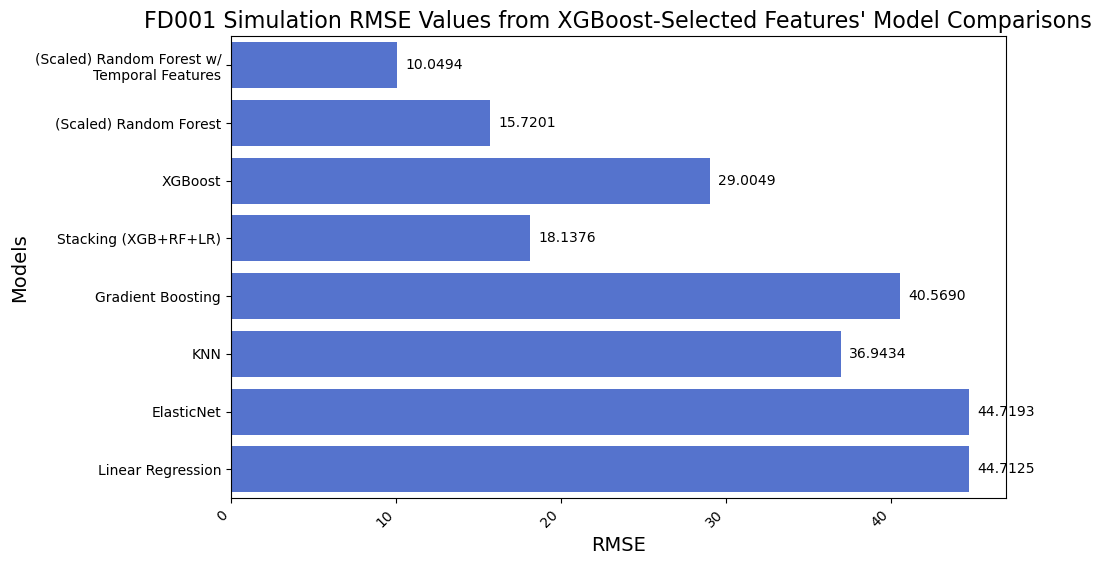

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

rmse_model_values = {
    '(Scaled) Random Forest w/ Temporal Features': 10.0494,
    '(Scaled) Random Forest': 15.7201, 
    'XGBoost': 29.0049,
    'Stacking (XGB+RF+LR)': 18.1376,  
    'Gradient Boosting': 40.5690, 
    'KNN': 36.9434,  
    'ElasticNet': 44.7193,  
    'Linear Regression': 44.7125,  
}

# wrap y-axis label text
wrapped_model_names = [textwrap.fill(model, width=30) for model in rmse_model_values.keys()]

rmse_xgb_df = pd.DataFrame(list(rmse_model_values.items()), columns=['Model', 'RMSE'])

rmse_xgb_df['Model'] = wrapped_model_names

plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=rmse_xgb_df, color='royalblue')

plt.title("FD001 Simulation RMSE Values from XGBoost-Selected Features' Model Comparisons", fontsize=16)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('Models', fontsize=14)

plt.xticks(rotation=45, ha='right')

# print RMSE values to the SIDE bars
for index, row in rmse_xgb_df.iterrows():
    plt.text(row['RMSE'] + 0.5, index, f"{row['RMSE']:.4f}", va='center', color='black')

plt.show()

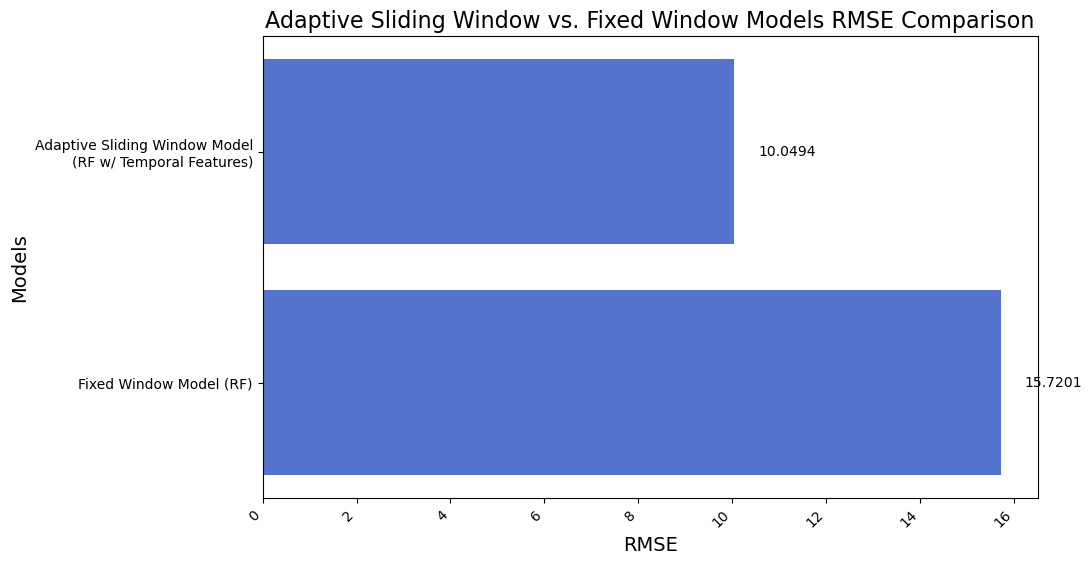

In [139]:
rmse_rf_values = {
    'Adaptive Sliding Window Model (RF w/ Temporal Features)': 10.0494,
    'Fixed Window Model (RF)': 15.7201,   
}

# wrap text
wrapped_models = [textwrap.fill(model, width=30) for model in rmse_rf_values.keys()]

rmse_rf_df = pd.DataFrame(list(rmse_rf_values.items()), columns=['Model', 'RMSE'])

rmse_rf_df['Model'] = wrapped_models

plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=rmse_rf_df, color='royalblue')

plt.title("Adaptive Sliding Window vs. Fixed Window Models RMSE Comparison", fontsize=16)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('Models', fontsize=14)

plt.xticks(rotation=45, ha='right')

for index, row in rmse_rf_df.iterrows():
    plt.text(row['RMSE'] + 0.5, index, f"{row['RMSE']:.4f}", va='center', color='black')

plt.show()

### Implementation of those 2 additional temporal features into Adaptive Sliding Window Random Forest model

BIG improvement; RMSE dropped from 15.72 (RF w/o temporal features | FIXED WINDOW) to 10.05 (w/ temporal features | ADAPTIVE)
- proves that temporal dependencies significantly improves RUL prediction --> TA gave very beneficia feedback in Milestone 2 submission.
- all models are trained under the same preprocessing conditions -->  RMSE comparisons to be fair and reliable

#### To ensure TA's comments from Milestone 2 are addressed:
- Rolling mean and standard deviation -->  capture local trends and variability
- Cumulative sum --> tracks degradation over time